In [1]:
import pandas as pd
import glob
import matplotlib
import numpy as np
%matplotlib inline
matplotlib.style.use('ggplot')
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn import svm
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import classification_report
import re


In [2]:
def import_folder(folder):
    filenames = glob.glob("data/" + folder + "/*.tsd")

    files = [file.split('\\')[1].split('.')[0] for file in filenames]

    signs = pd.DataFrame()
    for filename in files:
        df = pd.read_table('data/' + folder +'/' + filename + '.tsd', header=None)
        label = filename.split('-')[0]
        ID = filename.rsplit('-', 1)[1]
        df['label'] = label
        df['ID'] = int(ID)
        df.columns = ['x_L','y_L','z_L','roll_L','pitch_L','yaw_L','thumb_L','fore_L','middle_L','ring_L','little_L','x_R','y_R','z_R','roll_R','pitch_R','yaw_R','thumb_R','fore_R','middle_R','ring_R','little_R', 'label', 'ID']
        signs = signs.append(df)
        
    return signs

In [3]:
def temporal_scale(signs):
    IDs = signs['ID'].drop_duplicates().values
    labels = signs['label'].drop_duplicates().values
    signs_new = pd.DataFrame(columns = signs.columns)
    for ID in IDs:
        for sign in labels:

            df = signs[(signs['ID'] == ID) & (signs['label'] == sign)]

            df = df[['x_L', 'y_L', 'z_L', 'roll_L', 'pitch_L', 'yaw_L', 'thumb_L', 'fore_L',
                   'middle_L', 'ring_L', 'little_L', 'x_R', 'y_R', 'z_R', 'roll_R',
                   'pitch_R', 'yaw_R', 'thumb_R', 'fore_R', 'middle_R', 'ring_R',
                   'little_R']]

            df_new = pd.DataFrame(index=np.arange(57), columns = df.columns)

            for column in df:    
                column_resample = np.fft.irfft(np.fft.rfft(df[column]), 57)
                df_new[column] = column_resample

            df_new['label'] = sign
            df_new['ID'] = ID
            df_new['folder'] = folder
            signs_new = signs_new.append(df_new)
            #original = signs_new[['x_L', 'y_L', 'z_L', 'x_R', 'y_R', 'z_R']]
            #scaled = (original - original.min())/(original.max() - original.min())
            #signs_new[['x_L', 'y_L', 'z_L', 'x_R', 'y_R', 'z_R']] = scaled
    return signs_new

In [4]:
root='data'
signs_all = pd.DataFrame()
signs_all_ts = pd.DataFrame()
dirlist = [ item for item in os.listdir(root) if os.path.isdir(os.path.join(root, item)) ]
for folder in dirlist:
    print(folder)
    signs = import_folder(folder)
    signs_ts = temporal_scale(signs)
    signs_all = signs_all.append(signs)
    signs_all_ts = signs_all_ts.append(signs_ts)

tctodd1
tctodd2
tctodd3
tctodd4
tctodd5
tctodd6
tctodd7
tctodd8
tctodd9


In [5]:
def flatten(df):
    df2 = df
    df['frame'] = df.index + 1
    var = ['x_L', 'y_L', 'z_L', 'roll_L', 'pitch_L', 'yaw_L', 'thumb_L', 'fore_L',
                   'middle_L', 'ring_L', 'little_L', 'x_R', 'y_R', 'z_R', 'roll_R',
                   'pitch_R', 'yaw_R', 'thumb_R', 'fore_R', 'middle_R', 'ring_R',
                   'little_R']
    df = df[['x_L', 'y_L', 'z_L', 'roll_L', 'pitch_L', 'yaw_L', 'thumb_L', 'fore_L',
                   'middle_L', 'ring_L', 'little_L', 'x_R', 'y_R', 'z_R', 'roll_R',
                   'pitch_R', 'yaw_R', 'thumb_R', 'fore_R', 'middle_R', 'ring_R',
                   'little_R', 'label', 'frame']]
    df = df.pivot(columns = 'frame', index = 'label').reset_index()
    df.columns = [[str(e[0]) + str(e[1]) for e in df.columns.values.tolist()]]
    df['ID'] = df2['ID']
    df['folder'] = df2['folder']
    del df2
    return df

In [6]:
IDs = signs['ID'].drop_duplicates().values
labels = signs['label'].drop_duplicates().values

signs_flat = pd.DataFrame()
for folder in dirlist:
    for ID in IDs:
        for sign in labels:
            #print(ID, sign, folder)
            df = signs_all_ts[(signs_all_ts['ID'] == ID) & (signs_all_ts['label'] == sign) & (signs_all_ts['folder'] == folder)]
            signs_flat = signs_flat.append(flatten(df))

C:\Users\charu mulwani\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [7]:
X = signs_flat[signs_flat.columns[2:]]
del X['label']
Y = signs_flat['label']
le = LabelEncoder()
le.fit(Y)
Y = le.transform(Y)

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.40, random_state=42)



In [20]:
clf = svm.SVC(kernel='linear', C=10)
clf.fit(X_train, y_train)


SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [21]:
y_pred = clf.fit(X_train, y_train).predict(X_test)


In [14]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
#sum(y_pred == y_test)/len(y_test)

In [23]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

In [24]:
cnf_matrix

array([[ 7,  0,  0, ...,  0,  0,  0],
       [ 0,  9,  0, ...,  0,  0,  0],
       [ 0,  0, 14, ...,  0,  0,  0],
       ..., 
       [ 0,  0,  0, ..., 10,  0,  0],
       [ 0,  0,  0, ...,  0,  9,  0],
       [ 0,  0,  0, ...,  0,  0, 11]])

Confusion matrix, without normalization
[[ 7  0  0 ...,  0  0  0]
 [ 0  9  0 ...,  0  0  0]
 [ 0  0 14 ...,  0  0  0]
 ..., 
 [ 0  0  0 ..., 10  0  0]
 [ 0  0  0 ...,  0  9  0]
 [ 0  0  0 ...,  0  0 11]]


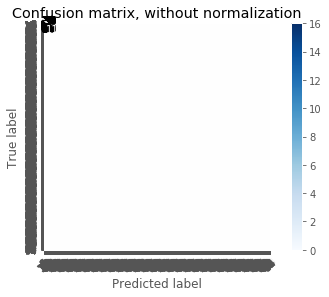

In [26]:
import itertools  
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=Y,
                      title='Confusion matrix, without normalization')

In [22]:
sum(y_pred == y_test)/len(y_test)

0.92487804878048785

In [86]:
sign_list = signs_flat.columns.values
sign_list
right_match = ['_L']
right_matching = [s for s in sign_list if any(xs in s for xs in right_match)]
left_matching = [s for s in sign_list if(s not in right_matching)]
left_signs_flat = signs_flat[left_matching]

In [87]:
X_left = left_signs_flat[left_signs_flat.columns[2:]]
del X_left['label']
Y_left = left_signs_flat['label']
le = LabelEncoder()
le.fit(Y_left)
Y_left = le.transform(Y_left)

In [88]:
X_train, X_test, y_train, y_test = train_test_split(X_left, Y_left, test_size=0.40, random_state=42)

In [89]:
clf = svm.SVC(kernel='linear', C=10)
clf.fit(X_train, y_train)

SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape=None, degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [90]:
y_pred = clf.fit(X_train, y_train).predict(X_test)
sum(y_pred == y_test)/len(y_test)

0.90146341463414636

In [84]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(y_test, y_pred)
np.set_printoptions(precision=2)

Confusion matrix, without normalization
[[4 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 1 1]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 2 0 ..., 1 1 0]
 [0 1 0 ..., 0 1 0]]


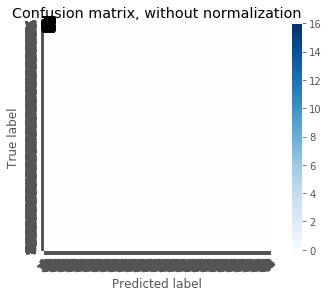

In [85]:
import itertools  
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=Y,
                      title='Confusion matrix, without normalization')